# Candle Patterns Strategy for Taiwan Stock Market Day Trading

<h2><mark>Note. Need Ta-Lib to be installed</mark></h2>
reference. https://pypi.org/project/TA-Lib/

# Data Setup

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data_filepath = 'data/data.feather'
data_df = pd.read_feather(data_filepath)
data_df.sort_index(ascending=True, inplace=True)

In [3]:
cdl_pattern_names = "2crows, 3blackcrows, 3inside, 3linestrike, 3outside, 3starsinsouth, 3whitesoldiers, abandonedbaby, advanceblock, belthold, breakaway, closingmarubozu, concealbabyswall, counterattack, darkcloudcover, doji, dojistar, dragonflydoji, engulfing, eveningdojistar, eveningstar, gapsidesidewhite, gravestonedoji, hammer, hangingman, harami, haramicross, highwave, hikkake, hikkakemod, homingpigeon, identical3crows, inneck, invertedhammer, kicking, kickingbylength, ladderbottom, longleggeddoji, longline, marubozu, matchinglow, mathold, morningdojistar, morningstar, onneck, piercing, rickshawman, risefall3methods, separatinglines, shootingstar, shortline, spinningtop, stalledpattern, sticksandwich, takuri, tasukigap, thrusting, tristar, unique3river, upsidegap2crows, xsidegap3methods"

In [4]:
ema_volume_length = 20

# Dictionary to collect computed results
results = {}

# Function to compute indicators for a given symbol
def compute_indicators(symbol):
    # Slice the dataframe once for the symbol
    df_symbol = data_df.xs(symbol, axis=1, level=1, drop_level=True).copy()
    df_symbol['Volume'] = df_symbol['Volume'].ffill()
    df_symbol['Value'] = df_symbol['Volume'].ffill() * df_symbol['Close'].ffill()

    # Calculate returns
    adj_close = df_symbol['Adj Close']
    open_price = df_symbol['Open']
    close = df_symbol['Close']
    adj_open = (open_price / close) * adj_close
    rtns = 100 * (adj_close - adj_open) / adj_open
    targets = 100 * (adj_close - adj_close.shift(1)) / adj_close.shift(1)
    gap = 100 * (adj_open - adj_close.shift(1)) / adj_close.shift(1)

    cdl = df_symbol.ta.cdl_pattern(name=[x for x in cdl_pattern_names.split(', ')]).sum(axis=1)    
    results[(f'i_CDL_SUM', symbol)] = cdl

    ema_volume = df_symbol.ta.ema(close='Volume', length=ema_volume_length)
    results[(f'i_EMA_Volume_{ema_volume_length}', symbol)] = ema_volume
    results[(f'i_EMA_Volume_{ema_volume_length}_lag1', symbol)] = ema_volume.shift(1)

    ema_value = df_symbol.ta.ema(close='Value', length=ema_volume_length)
    results[(f'i_EMA_Value_{ema_volume_length}', symbol)] = ema_value
    results[(f'i_EMA_Value_{ema_volume_length}_lag1', symbol)] = ema_value.shift(1)

    # Update the results
    results[(f"returns", symbol)] = rtns
    results[(f"targets", symbol)] = targets
    results[(f"gap", symbol)] = gap

symbols = data_df.columns.get_level_values(1).unique()

for s in tqdm(symbols):
    compute_indicators(s)

  0%|          | 0/1786 [00:00<?, ?it/s]

In [5]:
# Concatenate the original DataFrame with the computed results
data_df = pd.concat([data_df, pd.DataFrame(results)], axis=1)

In [6]:
data_df.xs('2330.TW', axis=1, level=1).tail()  # Inspect the result

,Adj Close,Close,High,Low,Open,Volume,i_CDL_SUM,i_EMA_Volume_20,i_EMA_Volume_20_lag1,i_EMA_Value_20,i_EMA_Value_20_lag1,returns,targets,gap
Date,,,,,,,,,,,,,,
2023-11-10,557.0,557.0,557.0,554.0,555.0,12994933.0,0.0,2.023411e+07,2.099613e+07,1.102306e+10,1.142146e+10,0.360360,0.000000,-0.359066
2023-11-13,571.0,571.0,580.0,571.0,579.0,43866014.0,0.0,2.248477e+07,2.023411e+07,1.235872e+10,1.102306e+10,-1.381693,2.513465,3.949731
2023-11-14,572.0,572.0,576.0,571.0,576.0,21568576.0,0.0,2.239751e+07,2.248477e+07,1.235667e+10,1.235872e+10,-0.694444,0.175131,0.875657
2023-11-15,581.0,581.0,583.0,575.0,583.0,50305088.0,0.0,2.505538e+07,2.239751e+07,1.396339e+10,1.235667e+10,-0.343053,1.573427,1.923077
2023-11-16,583.0,583.0,583.0,578.0,581.0,29048792.0,0.0,2.543570e+07,2.505538e+07,1.424644e+10,1.396339e+10,0.344234,0.344234,0.000000


In [7]:
data_df = data_df.iloc[-1260:]

# Trading Strategy

In [8]:
# Dictionary to collect computed results
results = {}

def gen_strategy_signals(symbol):
    df_symbol = data_df.xs(symbol, axis=1, level=1, drop_level=True)

    # Obtain the necessary series from df_symbol
    close = df_symbol['Close']
    open = df_symbol['Open']
    cdl = df_symbol['i_CDL_SUM']

    # Check for NaN values in any of the series
    nan_mask = close.isna() | open.isna() | cdl.isna()

    # Initialize signal series with zeros
    signal_series = pd.Series(np.zeros(len(df_symbol)), index=df_symbol.index)

    # Evaluate long conditions
    long_conditions = (cdl > 0)
    signal_series = signal_series.where(~long_conditions, 1)

    # Evaluate short conditions
    short_conditions = (cdl < 0)
    signal_series = signal_series.where(~short_conditions, -1)  

    # Set signals to 0 where any NaN value is present
    signal_series[nan_mask] = 0

    # Update the results
    results[(f"signal", symbol)] = signal_series.shift(1)

# Proceed signal marking
symbols = data_df.columns.get_level_values(1).unique()

for s in tqdm(symbols):
    gen_strategy_signals(s)

  0%|          | 0/1786 [00:00<?, ?it/s]

In [9]:
# Concatenate the original DataFrame with the computed results
data_df = pd.concat([data_df, pd.DataFrame(results)], axis=1)

# Stock Selection

## Split and filter the data

In [10]:
def data_filtering(train, test, valid):
    train_close = train['Close']
    train_volume = train['Volume']
    symbols = train_close.columns
    
    symbols_to_remove = []
    
    for symbol in symbols:
        if train_close[symbol].tail(252).isna().sum() > 120:
            symbols_to_remove.append(symbol)

    # filter the dfs
    filtered_train = train.drop(columns=symbols_to_remove, level=1)
    filtered_test = test.drop(columns=symbols_to_remove, level=1)
    filtered_valid = valid.drop(columns=symbols_to_remove, level=1)

    return filtered_train, filtered_test, filtered_valid 

# Split data_df into training and testing sets
train_size = int(len(data_df) * 0.8)
train_df = data_df.iloc[:train_size].copy()
test_df = data_df.iloc[train_size:].copy()

train_size = int(len(train_df) * 0.9)
valid_df = train_df.iloc[train_size:].copy()
train_df = train_df.iloc[:train_size].copy()

# Apply the data_filtering function
filtered_train_df, filtered_test_df, filtered_valid_df = data_filtering(train_df, test_df, valid_df)

## Refine the stock list

In [11]:
selected_symbols = filtered_train_df.columns.get_level_values(1).unique()
df_index = filtered_train_df.index

In [12]:
# Dictionary to store the results
stats_results = {}

for symbol in tqdm(selected_symbols):
    # Extract features and target for the current stock
    stock_data = data_df.xs(symbol, axis=1, level=1).loc[df_index].copy()

    # Calculate mean and stdev
    long_df = stock_data.loc[stock_data['signal'] == 1, 'targets']
    mean_long = long_df.mean()
    stdev_long = long_df.std()
    
    short_df = stock_data.loc[stock_data['signal'] == -1, 'targets']
    mean_short = short_df.mean()
    stdev_short = short_df.std()

    avg_volume = stock_data.loc[stock_data.index[-1], f'i_EMA_Volume_{ema_volume_length}'] / 1000
    avg_value = stock_data.loc[stock_data.index[-1], f'i_EMA_Value_{ema_volume_length}']
    
    # Store the results in the dictionary
    stats_results[symbol] = {
        'mean_long': mean_long,
        'stdev_long': stdev_long,
        'mean_short': mean_short,
        'stdev_short': stdev_short,
        'ratio_long': (mean_long / stdev_long) * (1 / avg_volume) * 10e5 if len(long_df.index) >= 10 else np.nan,
        'ratio_short': (mean_short / stdev_short) * (1 / avg_volume) * 10e5 if len(short_df.index) >= 10 else np.nan,
    }

# Convert the results dictionary to a DataFrame for better visualization
stats_df = pd.DataFrame(stats_results).T

  0%|          | 0/1750 [00:00<?, ?it/s]

# Backtest

## Apply stock selection

In [13]:
percentile_threshold = 80

long_ratio_values = [item['ratio_long'] for item in stats_results.values() if not np.isnan(item['ratio_long'])]
short_ratio_values = [item['ratio_short'] for item in stats_results.values() if not np.isnan(item['ratio_short'])]

top_percentile_long = max(0, np.percentile(long_ratio_values, percentile_threshold) if len(long_ratio_values) > 0 else np.nan)
top_percentile_short = min(0, np.percentile(short_ratio_values, (100 - percentile_threshold)) if len(short_ratio_values) > 0 else np.nan)

refined_selected_symbols = [s for s in selected_symbols \
                            if stats_results[s]['ratio_long'] > top_percentile_long or stats_results[s]['ratio_short'] < top_percentile_short]

# Sort the list to prioritize high expected value symbols
refined_selected_symbols = sorted(
    refined_selected_symbols,
    key=lambda symbol: (
        max(0, stats_results[symbol]['mean_long']) + max(0, -stats_results[symbol]['mean_short'])
    ),
    reverse=True,
)

print(f'Size of the refined selected symbols: {len(refined_selected_symbols)}')

Size of the refined selected symbols: 584


## Doing test

In [137]:
# The df use for the test
df = pd.concat([filtered_valid_df, filtered_test_df])

# Initial conditions and parameters
initial_capital = 200000
equity = initial_capital
fund_available = equity
fund_available_list = []
equity_curve = [initial_capital]
return_list = []
pnl_list = []
positions = {}  # Dictionary to track current positions
commission_rate = 0.002  # 0.2%

total_trade_value = 0
total_trade_count = 0
trade_value_list = []
position_value_list = []
position_share_list = []

last_day_trade_list = []

In [138]:
for date in tqdm(df.index):

    pnl = 0
    fund_available = min(equity_curve[-1] * 5, initial_capital * 5)  # Round-trip value limit: 10x capital
    position_sizing = 0.1
    residual_position_sizing = 0.2

    trade_value_list.append(0)

    # Get monitoring list
    long_list = []
    short_list = []
    priority_list = []
    
    # Get potential symbols to trade
    for symbol in refined_selected_symbols:
        stock_data = df.xs(symbol, axis=1, level=1).loc[date]
    
        match stock_data['signal']:
            case 1:
                long_list.append(symbol)
                priority_list.append(symbol)
                
            case -1:
                short_list.append(symbol)
                priority_list.append(symbol)
                
            case _:
                pass
        
    # Loop through each stock
    for symbol in refined_selected_symbols:        
        # Get stock data
        stock_data = df.xs(symbol, axis=1, level=1).loc[date]
        
        if any(np.isnan(x) for x in [stock_data['Open'], stock_data['Close'], stock_data['Adj Close'], stock_data['signal'], stock_data['Volume']]):  # Check if data is available
            continue

        close = stock_data['Close']
        open = stock_data['Open']
        adj_close = close # stock_data['Adj Close']
        adj_open = open # open * adj_close / close
        volume = stock_data['Volume']
        volume_ema_lag = stock_data[f'i_EMA_Volume_{ema_volume_length}_lag1']
        action = stock_data['signal']

        # Trade volume filter
        if np.isnan(volume_ema_lag) or (volume_ema_lag // 1000) < 100:
            continue

        # Position sizing adkustment
        try:
            if abs(action) > 0:
                position = priority_list.index(symbol)
                relative_pos = position / len(priority_list)
    
                if relative_pos < 0.1:
                    position_sizing = 0.2
                elif relative_pos < 0.4:
                    position_sizing = 0.15
        
        except ValueError:
            print(f"'{symbol}' is not in the list.")
            break
        
        # Execute action
        if abs(action) > 0:
            trade_filter = ( stock_data['gap'] < -3 ) if action == 1 else ( 1 < stock_data['gap'] )
            if trade_filter:        
                trade_side = action
                price = adj_open
                
                equity_adj = equity_curve[-1] / 1000  # 整張操作調整
                fund_available_adj = fund_available / 1000  # 整張操作調整
                
                try:
                    num_shares = int(equity_adj * position_sizing * (1 - commission_rate) / price)
                    num_shares_max = int(fund_available_adj * residual_position_sizing * (1 - commission_rate) / price)
                    num_shares = num_shares_max if num_shares > num_shares_max else num_shares
                except Exception as e:
                    print(f'date {date}, symbol {symbol}, stock_data {stock_data}')
                    print(f'equity_adj {equity_adj}, position_sizing {position_sizing}, commission_rate {commission_rate}, price {price}')

                # 交易量擬真調整
                num_share_volume_upper_bound = int((volume / 1000) / 20)
                if num_shares > num_share_volume_upper_bound:
                    num_shares = num_share_volume_upper_bound
                
                num_shares_adj = num_shares * 1000  # 整張操作調整
                
                if num_shares_adj > 0:
                    trade_value = num_shares_adj * price
                    total_trade_value += num_shares_adj * open
                    pnl -= trade_side * trade_value * (1 + trade_side * commission_rate)
                    fund_available -= trade_value * (1 + commission_rate)
                    positions[symbol] = {'action': action, 'num_shares': num_shares_adj, 'entry_date': date, 'entry_pruice': price}

                    position_value_list.append(num_shares_adj * open)
                    position_share_list.append(num_shares_adj)
                    trade_value_list[-1] += num_shares_adj * open
        
        # Close position (if any)
        if symbol in positions:
            days_held = (date - positions[symbol]['entry_date']).days
            if days_held >= 0:
                trade_side = -1 if positions[symbol]['action'] == 1 else 1
                num_shares = positions[symbol]['num_shares']
                trade_value = num_shares * adj_close
                total_trade_value += num_shares * close
                pnl -= trade_side * trade_value * (1 + trade_side * commission_rate)
                del positions[symbol]  # Remove position
                total_trade_count += 1

                trade_value_list[-1] += num_shares * close

            # Store the last day trading information
            if date == df.index[-1]:
                trade_detail = {
                    'symbol': symbol,
                    'action': action,
                    'share_traded': num_shares,
                    'value_traded': num_shares * open,
                    'pnl_percent': ((close - open) / open) * action
                }
                
                last_day_trade_list.append(trade_detail)
                
    # Calculate equity and daily return
    equity = equity_curve[-1] + pnl
    daily_return = (equity - equity_curve[-1]) / equity_curve[-1]
    pnl_list.append(pnl)
    fund_available_list.append(fund_available)
    return_list.append(daily_return)
    equity_curve.append(equity)

  0%|          | 0/353 [00:00<?, ?it/s]

## Performance metrics and statistics

In [139]:
# Calculate performance metrics
final_equity = equity_curve[-1]
total_return = (final_equity - initial_capital) / initial_capital
annualized_return = (1 + total_return) ** (252 / len(df.index)) - 1
annualized_sharpe_ratio = np.sqrt(252) * np.mean(return_list) / np.std(return_list)
profit_factor = sum([x for x in pnl_list if x > 0]) / abs(sum([x for x in pnl_list if x < 0]))
win_day_ratio = 100 * len([x for x in pnl_list if x > 0]) / len(pnl_list)

# Print performance metrics
print(f"Period: {df.index[0].date()} - {df.index[-1].date()}, {len(df.index)} trading days")
print(f"Initial Equity: ${initial_capital:.0f}")
print(f"Final Equity: ${final_equity:.0f}")
print(f"Total Rate of Return: {total_return * 100:.2f}%")
print(f"Annualized Rate of Return: {annualized_return * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Total Trade Count: {total_trade_count}")
print(f"Avg. Daily Trade Count: {total_trade_count / len(df.index) :.2f}")
print(f"Average PnL Percent: {100 * np.mean([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"Median PnL Percent: {100 * np.median([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"PnL Percent Stdev: {100 * np.std([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"Avg. PnL: {np.mean(pnl_list):.2f}")
print(f"Median PnL: {np.median(pnl_list):.2f}")
print(f"Max PnL: {np.max(pnl_list):.2f}")
print(f"Min PnL: {np.min(pnl_list):.2f}")
print(f"Win Day Ratio: {win_day_ratio:.2f}%")

Period: 2022-06-09 - 2023-11-16, 353 trading days
Initial Equity: $200000
Final Equity: $341548
Total Rate of Return: 70.77%
Annualized Rate of Return: 46.53%
Annualized Sharpe Ratio: 2.99
Profit Factor: 1.75
Total Trade Count: 1203
Avg. Daily Trade Count: 3.41
Average PnL Percent: 0.16%
Median PnL Percent: 0.09%
PnL Percent Stdev: 0.82%
Avg. PnL: 400.99
Median PnL: 235.80
Max PnL: 12219.30
Min PnL: -7125.11
Win Day Ratio: 56.37%


In [140]:
monthly_trade_value = (total_trade_value / len(df.index)) * (252 / 12)

print(f"Monthly Average Trade Value: {monthly_trade_value:.2f}")
print(f"Monthly Turnover Ratio Est.: {monthly_trade_value / ((initial_capital+final_equity) / 2):.2f}")

Monthly Average Trade Value: 4647124.63
Monthly Turnover Ratio Est.: 17.16


In [141]:
print(f'Max Daily Trade Value: {np.max(trade_value_list):.2f}')
print(f'Avg. Daily Trade Value: {np.mean(trade_value_list):.2f}')
print(f'Median Daily Trade Value: {np.median(trade_value_list):.2f}')
print(f'Median Position Size: {np.median(position_value_list):.2f}')
print(f'Max Position Size: {np.max(position_value_list):.2f}')
print(f'Min Position Size: {np.min(position_value_list):.2f}')
print(f'Median Position Share: {np.median(position_share_list):.2f}')
print(f'Max Position Share: {np.max(position_share_list):.2f}')
print(f'Min Position Share: {np.min(position_share_list):.2f}')
print(f'Error Check: {np.sum([x % 1000 for x in position_share_list]):.2f}')

Max Daily Trade Value: 1446189.09
Avg. Daily Trade Value: 221291.65
Median Daily Trade Value: 168600.00
Median Position Size: 31000.00
Max Position Size: 66600.00
Min Position Size: 6180.00
Median Position Share: 1000.00
Max Position Share: 7000.00
Min Position Share: 1000.00
Error Check: 0.00


## Visualization & Benchmark

### Metric function

In [142]:
import numpy as np

def information_ratio(strategy_returns, benchmark_returns):
    if len(strategy_returns) != len(benchmark_returns):
        print(f'strategy len {len(strategy_returns)}, benchmark len {len(benchmark_returns)}')
        raise ValueError("Strategy returns and benchmark returns must be of the same length")
    
    strategy_returns = np.array(strategy_returns)
    benchmark_returns = np.array(benchmark_returns)
    
    active_returns = strategy_returns - benchmark_returns
    tracking_error = np.std(active_returns)
    
    if tracking_error == 0:
        return np.nan
    
    information_ratio = np.mean(active_returns) / tracking_error
    return information_ratio

In [143]:
benchmark_last_day_returns = {}

### Benchmark 1: TSEC Weighted Index

In [144]:
import yfinance as yf

# Load benchmark
index_df = yf.download(['^TWII'], start=df.index[0], end=df.index[-1], progress=True)

[*********************100%%**********************]  1 of 1 completed


In [145]:
import statsmodels.api as sm

strategy_returns = return_list[1:]
benchmark_returns = index_df['Adj Close'].pct_change().fillna(0)

benchmark_last_day_returns['TSEC'] = benchmark_returns.iloc[-1]

# Information Ratio
ir_annulized = information_ratio(strategy_returns, benchmark_returns) * np.sqrt(252)

# Alpha & Beta
X = np.array(benchmark_returns).reshape(-1, 1)
y = np.array(strategy_returns).reshape(-1, 1)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
alpha, beta = model.params
annual_alpha = alpha * 252
alpha_pvalue = model.pvalues[0]

print(f'Information Ratio (Annualized): {ir_annulized:0.4f}')
print(f'Alpha (Annualized): {annual_alpha:0.4f} (p-value {alpha_pvalue:0.4f})')
print(f'Beta: {beta:0.4f}')

Information Ratio (Annualized): 1.7170
Alpha (Annualized): 0.3905 (p-value 0.0005)
Beta: 0.0420


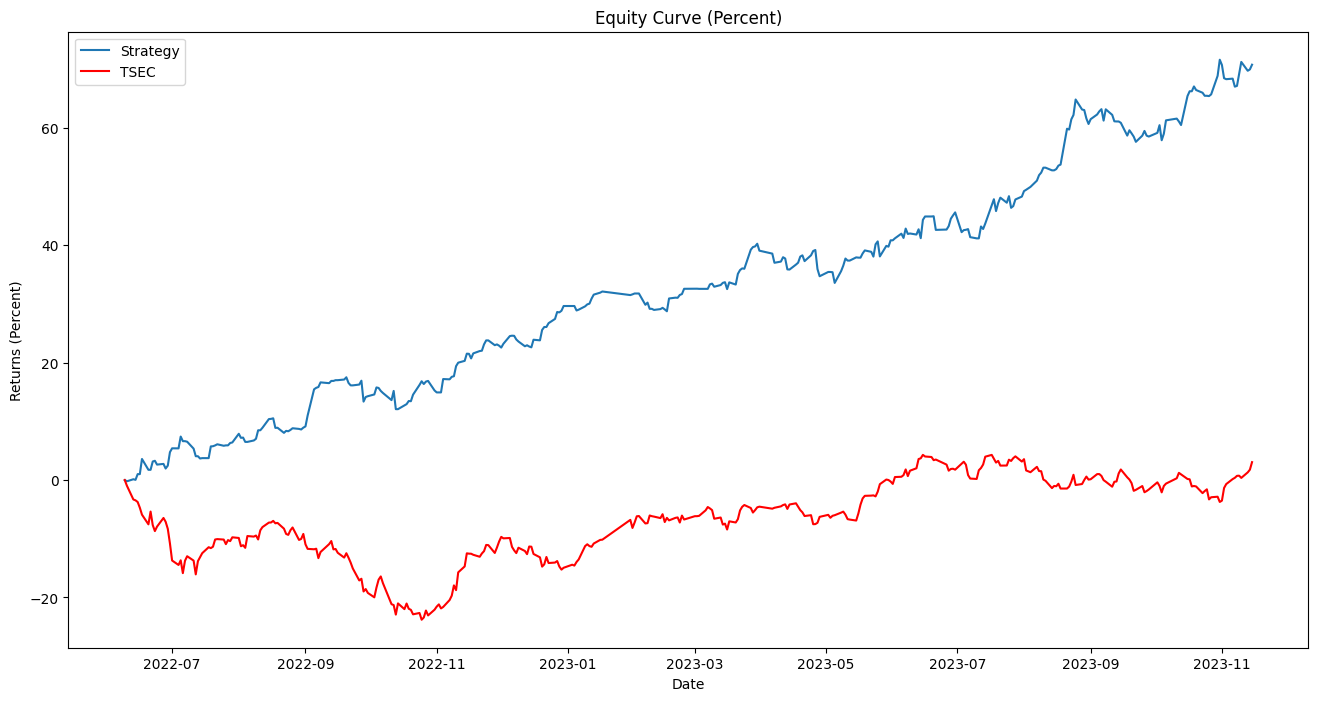

In [146]:
import matplotlib.pyplot as plt

# Plot equity curve
plt.figure(figsize=(16, 8))
plt.plot(df.index[:-1], [((x / initial_capital) - 1) * 100 for x in equity_curve[2:]], label="Strategy")
plt.plot(index_df.index, [x * 100 for x in (index_df['Adj Close'] / index_df['Adj Close'].iloc[0] - 1)], label="TSEC", color='red')
plt.title('Equity Curve (Percent)')
plt.xlabel('Date')
plt.ylabel('Returns (Percent)')
plt.legend(loc='upper left')
plt.show()

### Benchmark 2: 0050

In [131]:
import yfinance as yf

# Load benchmark
index_df = yf.download(['0050.TW'], start=df.index[0], end=df.index[-1], progress=True)

[*********************100%%**********************]  1 of 1 completed


In [132]:
import statsmodels.api as sm

strategy_returns = return_list[1:]
benchmark_returns = index_df['Adj Close'].pct_change().fillna(0)

benchmark_last_day_returns['0050'] = benchmark_returns.iloc[-1]

# Information Ratio
ir_annulized = information_ratio(strategy_returns, benchmark_returns) * np.sqrt(252)

# Alpha & Beta
X = np.array(benchmark_returns).reshape(-1, 1)
y = np.array(strategy_returns).reshape(-1, 1)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
alpha, beta = model.params
annual_alpha = alpha * 252
alpha_pvalue = model.pvalues[0]

print(f'Information Ratio (Annualized): {ir_annulized:0.4f}')
print(f'Alpha (Annualized): {annual_alpha:0.4f} (p-value {alpha_pvalue:0.4f})')
print(f'Beta: {beta:0.4f}')

Information Ratio (Annualized): 1.4453
Alpha (Annualized): 0.3918 (p-value 0.0005)
Beta: 0.0033


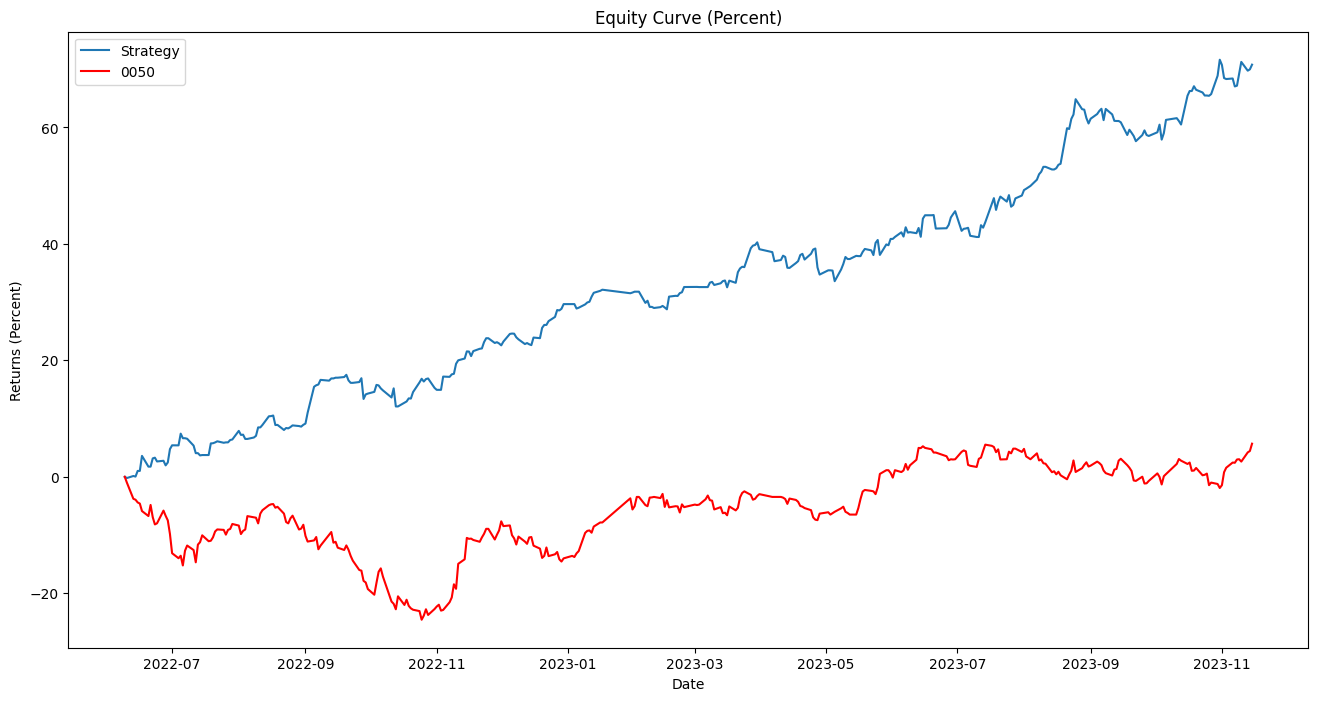

In [133]:
import matplotlib.pyplot as plt

# Plot equity curve
plt.figure(figsize=(16, 8))
plt.plot(df.index[:-1], [((x / initial_capital) - 1) * 100 for x in equity_curve[2:]], label="Strategy")
plt.plot(index_df.index, [x * 100 for x in (index_df['Adj Close'] / index_df['Adj Close'].iloc[0] - 1)], label="0050", color='red')
plt.title('Equity Curve (Percent)')
plt.xlabel('Date')
plt.ylabel('Returns (Percent)')
plt.legend(loc='upper left')
plt.show()

# Store the daily results

In [27]:
import os
import json
import builtins

daily_results_file_path = 'results/daily_results_Candle_Patterns_Strategy.json'

In [28]:
daily_results = []

if os.path.exists(daily_results_file_path):
    # Load from JSON file
    with builtins.open(daily_results_file_path, 'r', encoding='utf-8') as f:
        daily_results = json.load(f)  # Load from JSON file

In [29]:
# The result of today
result_today = {
    'date': df.index[-1].date(),
    'trade_list': last_day_trade_list,
    'period_start_equity': equity_curve[-2],
    'period_end_equity': equity_curve[-1],
    'daily_return_strategy': (equity_curve[-1] - equity_curve[-2]) / equity_curve[-2],
    'daily_return_bechmark_TSEC': benchmark_last_day_returns['TSEC'],
    'daily_return_bechmark_0050': benchmark_last_day_returns['0050'],
}

In [30]:
from datetime import datetime, timedelta, timezone

# Convert the current UTC time to UTC+8 timezone
now_utc8 = datetime.now(timezone(timedelta(hours=8)))

# Check if the current time is after 3 PM UTC+8
if now_utc8.hour >= 15:
    # Check if the last date in df is the same as today's date
    if df.index[-1].date() == now_utc8.date():
        # Check if daily_results does not have any element with 'date' the same as 'date' of result_today
        if not daily_results or (not any(datetime.strptime(result['date'], '%Y-%m-%d').date() == result_today['date'] for result in daily_results)):
            daily_results.append(result_today)
            print('daily_results updated!')

In [31]:
# Save to JSON file
# with builtins.open(daily_results_file_path, 'w', encoding='utf-8') as f:
#     json.dump(daily_results, f, default=str, ensure_ascii=False, indent=4)

In [32]:
daily_results

[{'date': '2023-11-01',
  'trade_list': [{'symbol': '6799.TW',
    'action': -1.0,
    'share_traded': 4000,
    'value_traded': 478000.0,
    'pnl_percent': 0.02092050209205021},
   {'symbol': '6741.TWO',
    'action': -1.0,
    'share_traded': 4000,
    'value_traded': 378000.0,
    'pnl_percent': 0.002116369822668651},
   {'symbol': '6642.TWO',
    'action': -1.0,
    'share_traded': 1000,
    'value_traded': 47299.99923706055,
    'pnl_percent': 0.027484128076728807},
   {'symbol': '3713.TWO',
    'action': -1.0,
    'share_traded': 1000,
    'value_traded': 23299.999237060547,
    'pnl_percent': -0.05793993243237712},
   {'symbol': '6792.TW',
    'action': -1.0,
    'share_traded': 2000,
    'value_traded': 205000.0,
    'pnl_percent': 0.004878048780487805},
   {'symbol': '6806.TW',
    'action': -1.0,
    'share_traded': 2000,
    'value_traded': 203000.0,
    'pnl_percent': -0.024630541871921183},
   {'symbol': '2243.TW',
    'action': -1.0,
    'share_traded': 2000,
    'value_

# Print potential stocks to trade for the next day

In [147]:
long_list = []
short_list = []
priority_list = []

# Symbols for tomorrow
for symbol in refined_selected_symbols:
    stock_data = df.xs(symbol, axis=1, level=1).loc[df.index[-1]]

    # Trade volume filter
    volume_ema_lag = stock_data[f'i_EMA_Volume_{ema_volume_length}_lag1']
    if np.isnan(volume_ema_lag) or (volume_ema_lag // 1000) < 100:
        continue

    match stock_data['signal']:
        case 1:
            long_list.append(symbol)
            priority_list.append(symbol)
            
        case -1:
            short_list.append(symbol)
            priority_list.append(symbol)
            
        case _:
            pass

# Show the result
print(f'做多監控個股 ({len(long_list)} 檔): {long_list}\n')
print(f'做空監控個股 ({len(short_list)} 檔): {short_list}\n')
print(f'優先順序: {priority_list}')

做多監控個股 (23 檔): ['6799.TW', '5340.TWO', '3289.TWO', '2427.TW', '8341.TW', '6741.TWO', '1215.TW', '5386.TWO', '5703.TWO', '6667.TWO', '6703.TWO', '6683.TWO', '4726.TWO', '3437.TW', '4999.TW', '1789.TW', '3171.TWO', '3709.TWO', '8906.TWO', '6689.TW', '8089.TWO', '4581.TW', '1436.TW']

做空監控個股 (64 檔): ['8227.TWO', '3044.TW', '3138.TW', '1781.TWO', '5225.TW', '5236.TWO', '8358.TWO', '6789.TW', '6515.TW', '3580.TWO', '3131.TWO', '6569.TWO', '3338.TW', '2453.TW', '3615.TWO', '2250.TW', '2404.TW', '5439.TWO', '1736.TW', '6558.TW', '3004.TW', '6792.TW', '6209.TW', '5465.TWO', '5203.TW', '3583.TW', '4147.TWO', '6535.TWO', '6148.TWO', '3152.TWO', '3081.TWO', '6732.TWO', '8446.TWO', '2413.TW', '5511.TWO', '8390.TWO', '9924.TW', '6579.TW', '6158.TWO', '2493.TW', '8432.TWO', '8942.TWO', '6114.TWO', '1737.TW', '9950.TWO', '8426.TWO', '3523.TWO', '6668.TW', '5381.TWO', '8249.TW', '4129.TWO', '4763.TW', '4909.TWO', '5410.TWO', '8109.TWO', '1463.TW', '3213.TWO', '5534.TW', '4973.TWO', '6664.TWO', '8043.T